In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io
import skimage.transform
import urllib
import requests
from io import BytesIO

import flickrapi

api_key = '134871c5bf05982504099e45035e58b3'
api_secret = '657d30d0e6253fa8'

flickr = flickrapi.FlickrAPI(api_key,api_secret)

keyword1 = 'car'
keyword2 = 'bicycle'

carphotos = flickr.walk(text=keyword1, tag_mode='all', tags=keyword1,extras='url_c', sort='relevance',per_page=100)
bicyclephotos = flickr.walk(text=keyword2, tag_mode='all', tags=keyword2,extras='url_c', sort='relevance',per_page=100)

In [10]:
import os

# declare directory names
train_dir = 'train'
test_dir = 'test'
image_dir1 = keyword1
image_dir2 = keyword2

# make a directories for the training and testing images
for root_dir in [train_dir,test_dir]:
    dir_path = root_dir + '/' + image_dir1

    # check if data exists
    if not os.path.isdir(root_dir):
        os.mkdir(root_dir)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
        print("Making directory %s" % dir_path)
    else:
        print("Will store %s images in directory %s" %(root_dir,dir_path))
        
for root_dir in [train_dir,test_dir]:
    dir_path = root_dir + '/' + image_dir2

    # check if data exists
    if not os.path.isdir(root_dir):
        os.mkdir(root_dir)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
        print("Making directory %s" % dir_path)
    else:
        print("Will store %s images in directory %s" %(root_dir,dir_path))

Will store train images in directory train/car
Will store test images in directory test/car
Will store train images in directory train/bicycle
Will store test images in directory test/bicycle


In [7]:
import warnings
from random import seed
from random import random
    
ntrain = 1000 # number of training images to download
ntest = 300 # number of testing images to download

nrow = 224 # image dimension 1
ncol = 224 # image dimension 2

# download images, first train then test
seed(1) # make repeatable
itrain = 0 # initialize counter
itest = 0 # initialize counter
for photo in carphotos:
    url=photo.get('url_c')
    if not (url is None):
        
        # Create a file from the URL
        # This may only work in Python3
        response = requests.get(url)
        file = BytesIO(response.content)
        
        # Read image from file
        im = skimage.io.imread(file)
        
        # Resize images
        im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
                
        # Convert to uint8, suppress the warning about the precision loss
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im2 = skimage.img_as_ubyte(im1)
    
        # Set the directory randomly 
        #if (random()< ntrain/(ntrain+ntest)):
        if (random()< (ntrain-itrain)/(ntrain-itrain + ntest-itest + 1e-15)):
            if (itrain<ntrain):
                dir_path = train_dir + '/' + image_dir1
                i = itrain
                itrain = itrain + 1
            elif (itest<ntest):
                dir_path = test_dir + '/' + image_dir1
                i = itest
                itest = itest + 1
            else:
                break
        else:
            if (itest<ntest):
                dir_path = test_dir + '/' + image_dir1
                i = itest
                itest = itest + 1
            elif (itrain<ntrain):
                dir_path = train_dir + '/' + image_dir1
                i = itrain
                itrain = itrain + 1
            else:
                break            
    
        # Save the image
        local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_path,keyword1,i)  
        skimage.io.imsave(local_name, im2)

In [9]:
seed(1) # make repeatable
itrain = 0 # initialize counter
itest = 0 # initialize counter
for photo in bicyclephotos:
    url=photo.get('url_c')
    if not (url is None):
        
        # Create a file from the URL
        # This may only work in Python3
        response = requests.get(url)
        file = BytesIO(response.content)
        
        # Read image from file
        im = skimage.io.imread(file)
        
        # Resize images
        im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
                
        # Convert to uint8, suppress the warning about the precision loss
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im2 = skimage.img_as_ubyte(im1)
    
        # Set the directory randomly 
        #if (random()< ntrain/(ntrain+ntest)):
        if (random()< (ntrain-itrain)/(ntrain-itrain + ntest-itest + 1e-15)):
            if (itrain<ntrain):
                dir_path = train_dir + '/' + image_dir2
                i = itrain
                itrain = itrain + 1
            elif (itest<ntest):
                dir_path = test_dir + '/' + image_dir2
                i = itest
                itest = itest + 1
            else:
                break
        else:
            if (itest<ntest):
                dir_path = test_dir + '/' + image_dir2
                i = itest
                itest = itest + 1
            elif (itrain<ntrain):
                dir_path = train_dir + '/' + image_dir2
                i = itrain
                itrain = itrain + 1
            else:
                break            
    
        # Save the image
        local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_path,keyword2,i)  
        skimage.io.imsave(local_name, im2)      

Selecting the image dimensions for our neural network.

In [11]:
nrow = 150
ncol = 150


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

train_dir = './train'
data_transform = transforms.Compose([transforms.RandomResizedCrop((nrow,ncol), scale=(0.5,1)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_ds = ImageFolder(train_dir, transform=data_transform)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# Create data set using ImageFolder

 `test_dl` object for the test data, using the same data transform as for the training.

In [14]:
test_ds = ImageFolder(test_dir, transform=data_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

# Create test data loader similar to above

Image display function.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Code from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html #####
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # rearrange dimensions from (color,y,x) -> (y,x,color)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # undo the normalization
    inp = np.clip(inp, 0, 1)
    # Display image, without ticks
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)

###########################################################################################

To see how the `train_dl` works

torch.Size([32, 3, 150, 150]) torch.Size([32])


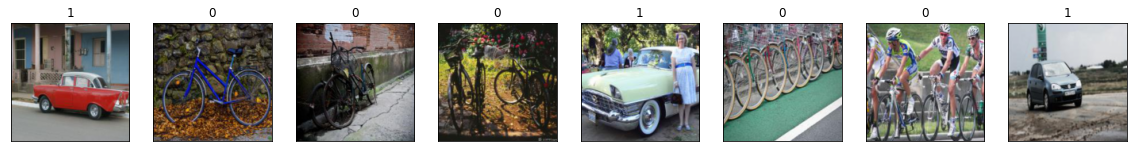

In [16]:
X,y = next(iter(train_dl))
print(X.size(), y.size())
nplot = 8
plt.figure(figsize=(20,20))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    imshow(X[i], title=str(int(y[i])))

## Loading a Pre-Trained Deep Network

In [17]:
import torch
from torchvision.models import vgg16

#Load the VGG16 network
model = vgg16(pretrained=True)


In [18]:
for param in model.parameters():
    param.requires_grad = False


print(model.classifier[0])

Linear(in_features=25088, out_features=4096, bias=True)


Replace `model.classifier` with a neural network consisting of the following layers:
* Linear w/ 256 output channels
* ReLU
* Dropout w/ p = 0.5
* Linear w/ 1 output channel (indicating car vs bike)
* Sigmoid

This network can be constructed using 1 line via `nn.Sequential`.

In [19]:
import torch.nn as nn

#Replace the classifier part of the network
model.classifier = nn.Sequential(nn.Linear(25088,256), nn.ReLU(), nn.Dropout(p=0.5), nn.Linear(256,1), nn.Sigmoid())


Now we will print a summary of the model.

In [20]:
print(str(model))

import torch.optim as optim

lr = 1e-3

# loss and optimizer
criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(),lr=lr)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now, run the training.  If you are using a CPU on a regular laptop, each epoch should take about 1-4 minutes, so you should be able to finish 5 epochs or so within 5-20 minutes.  On a reasonable GPU, it should take about 10 seconds per epoch.

In [21]:
import time

num_epoch = 5

a_tr_loss = np.zeros([num_epoch])
a_tr_accuracy = np.zeros([num_epoch])
a_ts_loss = np.zeros([num_epoch])
a_ts_accuracy = np.zeros([num_epoch])

for epoch in range(num_epoch):
    correct = 0
    total = 0
    batch_loss = []
    tic = time.time()
    model.train()
    for train_iter, data in enumerate(train_dl):
        x_batch,y_batch = data
        y_batch = y_batch.view(-1,1)
        out = model(x_batch)
        
        # Loss
        
        loss = criterion(out,y_batch.type(torch.float))
        batch_loss.append(loss.item())
        
        # Zero gradients
        
        opt.zero_grad()
        
        # back propagation
        
        loss.backward()
        
        # optimiation steps
        
        opt.step()
        
        predicted = out.clamp(0,1).round().type(torch.long)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss[epoch] = np.mean(batch_loss)
    a_tr_accuracy[epoch] = 100*correct/total
    
    correct = 0
    total = 0
    batch_loss = []
    model.eval()
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            labels = labels.view(-1,1)
            out = model(images)
            batch_loss.append(criterion(out,labels.type(torch.float)).item())
            predicted = out.clamp(0,1).round().type(torch.long)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss[epoch] = np.mean(batch_loss)
    a_ts_accuracy[epoch] = 100*correct/total
    elapsed = time.time()-tic
    
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch]) + 'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch]) + 'Test Accuracy: {0:.2f}   '.format(a_ts_accuracy[epoch]) + 'Time: {0:.2f}sec'.format(elapsed))


Epoch:  1   Train Loss: 0.391   Train Accuracy: 97.95    Test Loss: 0.233   Test Accuracy: 99.00   Time: 91.71sec
Epoch:  2   Train Loss: 0.342   Train Accuracy: 98.50    Test Loss: 0.403   Test Accuracy: 99.00   Time: 82.69sec
Epoch:  3   Train Loss: 0.262   Train Accuracy: 99.10    Test Loss: 0.377   Test Accuracy: 99.17   Time: 84.50sec
Epoch:  4   Train Loss: 0.174   Train Accuracy: 99.20    Test Loss: 0.218   Test Accuracy: 99.17   Time: 83.27sec
Epoch:  5   Train Loss: 0.190   Train Accuracy: 99.25    Test Loss: 0.299   Test Accuracy: 99.17   Time: 83.82sec


Example test images with their predicted and actual labels in the title.

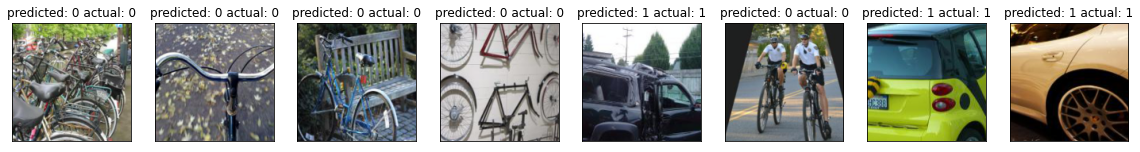

In [22]:
n_show = 8
view_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
plt.figure(figsize=(20,20))

with torch.no_grad():
    for i, data in enumerate(view_dl):
        if i>= n_show:
            break
        images, labels = data
        out = model(images)
        predicted = str(int(out.clamp(0,1).round()))
        plt.subplot(1, n_show, i+1)
        imshow(images[0], title='predicted: ' + predicted + ' actual: ' + str(int(labels[0])))